In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Load dataset
data = pd.read_csv('C:/Users/Imran/OneDrive - Ontario Tech University/Documents/Capstone/0.5_test_GA.csv')

In [3]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [4]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



In [5]:
#transform data into target variable and features
labels = data['target']
features_scaled = data.drop(['target'], axis=1, errors='ignore')

### Creating the individual model

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

In [7]:
# Define and train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [8]:
# Evaluate the model
predictions = gb_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test R²: {r2}")


Test MSE: 754217.8145330388
Test RMSE: 868.4571460544491
Test MAE: 507.1991816337282
Test R²: 0.9917987504900556


In [9]:
# Display the first 5 predictions
print("First 5 predictions:", predictions[:5])
print("First 5 actual values:", y_test[:5])

First 5 predictions: [5634.77246309 4227.85603605 8382.03172367 2664.14410399 5582.69129256]
First 5 actual values: 187826     5634.500
934322     4216.800
182019     8965.312
1291636    2674.820
254180     5701.320
Name: target, dtype: float64


### Creating the hybrid model

In [10]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

In [11]:
# Create a DataFrame to hold the features and clusters
data_km = features_scaled
data_km['label'] = labels
data_km['cluster'] = clusters

In [13]:
# Function to train Gradient Boosting on a specific cluster
def train_gb_on_cluster(cluster_data):
    features = cluster_data.drop(['label', 'cluster'], axis=1)
    labels = cluster_data['label']
    
    X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gb_model.fit(X_train_cluster, y_train_cluster)
    
    return gb_model

In [14]:
# Training a Gradient Boosting model for each cluster
gb_models = {}
for cluster in range(3):
    cluster_data = data_km[data_km['cluster'] == cluster]
    gb_models[cluster] = train_gb_on_cluster(cluster_data)

In [15]:
# Assign each sample in the test set to a cluster
test_clusters = kmeans.predict(X_test)

In [16]:
# Initialize an array to hold the predictions
combined_predictions = np.zeros_like(y_test)

In [17]:
# Make predictions using the corresponding model for each cluster
for cluster in range(3):
    cluster_indices = np.where(test_clusters == cluster)[0]
    if len(cluster_indices) > 0:
        X_cluster = X_test.iloc[cluster_indices]  # Use NumPy indexing
        model = gb_models[cluster]
        combined_predictions[cluster_indices] = model.predict(X_cluster).flatten()

# Evaluate the combined performance
combined_mse = mean_squared_error(y_test, combined_predictions)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(y_test, combined_predictions)
combined_r2 = r2_score(y_test, combined_predictions)

print(f'Combined Model MSE: {combined_mse}')
print(f'Combined Model RMSE: {combined_rmse}')
print(f'Combined Model MAE: {combined_mae}')
print(f'Combined Model R²: {combined_r2}')


Combined Model MSE: 573530.9646210453
Combined Model RMSE: 757.3182716804378
Combined Model MAE: 419.972595578926
Combined Model R²: 0.9937635117443514


In [18]:
# Evaluate the model
predictions = gb_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print additional metrics
print(f"Single Model MSE: {mse}")
print(f"Single Model RMSE: {rmse}")
print(f"Single Model MAE: {mae}")
print(f"Single Model R²: {r2}")

Single Model MSE: 754217.8145330388
Single Model RMSE: 868.4571460544491
Single Model MAE: 507.1991816337282
Single Model R²: 0.9917987504900556


In [42]:
#create a dataframe of scores
performance_metrics = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Single Model': [mse, rmse, mae, r2],
    'Combined Model': [combined_mse, combined_rmse, combined_mae, combined_r2]
})



In [44]:
# Export the performance metrics to a CSV file
performance_metrics.to_csv('performance_metrics_GB_GA.csv', index=False)

In [85]:
# Get feature importances
importances = gb_model.feature_importances_

# Get the indices that would sort the importances array in descending order
sorted_indices = np.argsort(importances)[::-1]

# Display top 5 feature importance
top_n = 5
for i in range(top_n):
    print(f"Feature {sorted_indices[i]}: Importance {importances[sorted_indices[i]]}")

Feature 20: Importance 0.8726673164598572
Feature 7: Importance 0.0808242520519837
Feature 11: Importance 0.02344480328438175
Feature 1: Importance 0.01067421796281319
Feature 9: Importance 0.004461274035545616


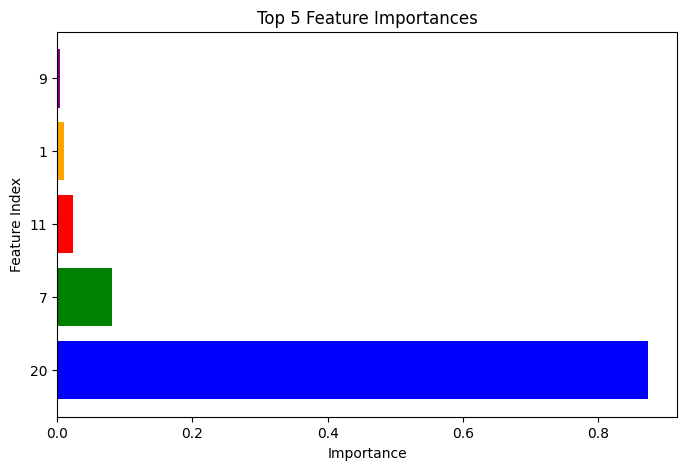

In [87]:
# Define colors for bars
colors = ['blue', 'green', 'red', 'orange', 'purple']

# Plot horizontal bar chart of top 5 feature importances with different colors
top_n = 5
plt.figure(figsize=(8, 5))
plt.barh(range(top_n), importances[sorted_indices][:top_n], align='center', color=colors)
plt.yticks(range(top_n), sorted_indices[:top_n])
plt.xlabel('Importance')
plt.ylabel('Feature Index')
plt.title('Top 5 Feature Importances')
plt.show()

In [89]:
# Get feature importances
importances = model.feature_importances_

# Get the indices that would sort the importances array in descending order
sorted_indices = np.argsort(importances)[::-1]

# Display top 5 feature importance
top_n = 5
for i in range(top_n):
    print(f"Feature {sorted_indices[i]}: Importance {importances[sorted_indices[i]]}")

Feature 20: Importance 0.8293922382819431
Feature 11: Importance 0.05819870748097574
Feature 7: Importance 0.042725104507220474
Feature 1: Importance 0.03092061097452101
Feature 21: Importance 0.023874325784805257


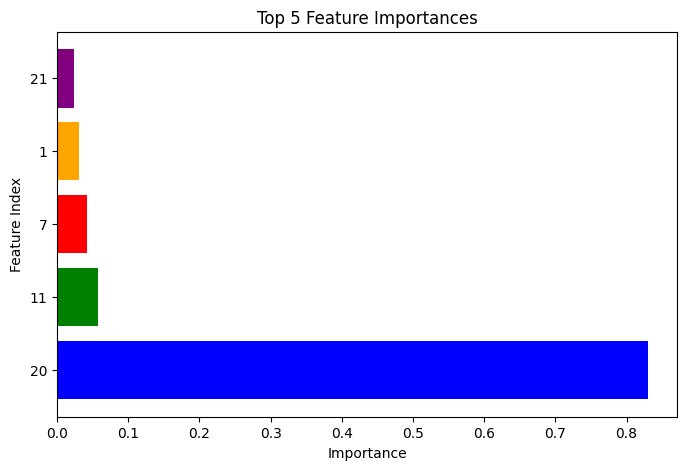

In [91]:
# Define colors for bars
colors = ['blue', 'green', 'red', 'orange', 'purple']

# Plot horizontal bar chart of top 5 feature importances with different colors
top_n = 5
plt.figure(figsize=(8, 5))
plt.barh(range(top_n), importances[sorted_indices][:top_n], align='center', color=colors)
plt.yticks(range(top_n), sorted_indices[:top_n])
plt.xlabel('Importance')
plt.ylabel('Feature Index')
plt.title('Top 5 Feature Importances')
plt.show()